In [15]:
#Import libraries
import os
import zipfile
from PIL import Image
import os.path
import glob
import cv2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset
from torchsummary import summary

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#Uplad kaggle json
import json

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"YOUR_USERNAME","key":"YOUR_KEY"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download data
!kaggle competitions download -c denoising-dirty-documents

In [ ]:
test_zip = 'test.zip'
train_zip = 'train.zip'
train_cleaned_zip = 'train_cleaned.zip'
zipped = [test_zip, train_zip, train_cleaned_zip]

for zipp in zipped:
  zip_ref = zipfile.ZipFile(zipp, 'r')
  zip_ref.extractall('')
  zip_ref.close()

In [ ]:
!mkdir -p /train/tr
!mkdir -p /test/ts
!mkdir -p /train_cleaned/tr_cleaned

In [ ]:
!mv -v train/*.png /train/tr
!mv -v test/*.png /test/ts
!mv -v train_cleaned/*.png /train_cleaned/tr_cleaned

In [ ]:
width=420
height=540

test = '/test'
train = '/train'
train_cleaned = '/train_cleaned'

In [ ]:
transform = transforms.Compose([transforms.Resize((540, 420)),
                               transforms.ToTensor()])

In [ ]:
class Docs(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.total_imgs = sorted(os.listdir(main_dir))

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc)
        tensor_image = self.transform(image)
        return tensor_image

In [ ]:
# Creating datasets
docs_test = Docs(test, transform=transform)
docs_train_x = Docs(train, transform=transform)
docs_train_y = Docs(train_cleaned, transform=transform)

In [ ]:
# split Train, validation
X_train, X_val, y_train, y_val = train_test_split(docs_train_x, docs_train_y, test_size = 0.15)

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    # encoding
    self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, padding='same'), 
                                nn.ReLU(), 
                                nn.Conv2d(32, 64, kernel_size=3, padding='same'), 
                                nn.ReLU(), 
                                nn.LazyBatchNorm2d(),
                                nn.MaxPool2d(kernel_size=1),
                                nn.Dropout(.5))
    # decoding
    self.layer2 = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
                                nn.ReLU(), 
                                nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.LazyBatchNorm2d(),
                                )
    
    self.last_layer = nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1)
        
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.last_layer(out)
    out = torch.sigmoid(out)
    return out

model = CNN()
model.to(device)

# set loss
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
summary(model, (1, width, height))
history = None

In [ ]:
# train model
losses = []
accs = []
epochs = 1

for epoch in np.arange(epochs):
    print(f'Epoch # {epoch+1} started .. ')
    for i, (dirty, clean) in enumerate(zip(X_train, y_train)):
      dirty = torch.Tensor(np.expand_dims(dirty, axis=1))
      clean = torch.Tensor(np.expand_dims(clean, axis=1))
      
      outputs = model(dirty)
      loss = loss_fn(outputs, clean)
      losses.append(loss)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      preds = outputs.detach().numpy()
      correct = mean_squared_error(np.squeeze(preds), np.squeeze(clean))
      accs.append(correct)

In [ ]:
preds = []
for test in X_val[:8]:
  test = torch.Tensor(np.expand_dims(test, axis=1))
  outputs_test = model(test)
  preds.append(outputs_test.detach().numpy())

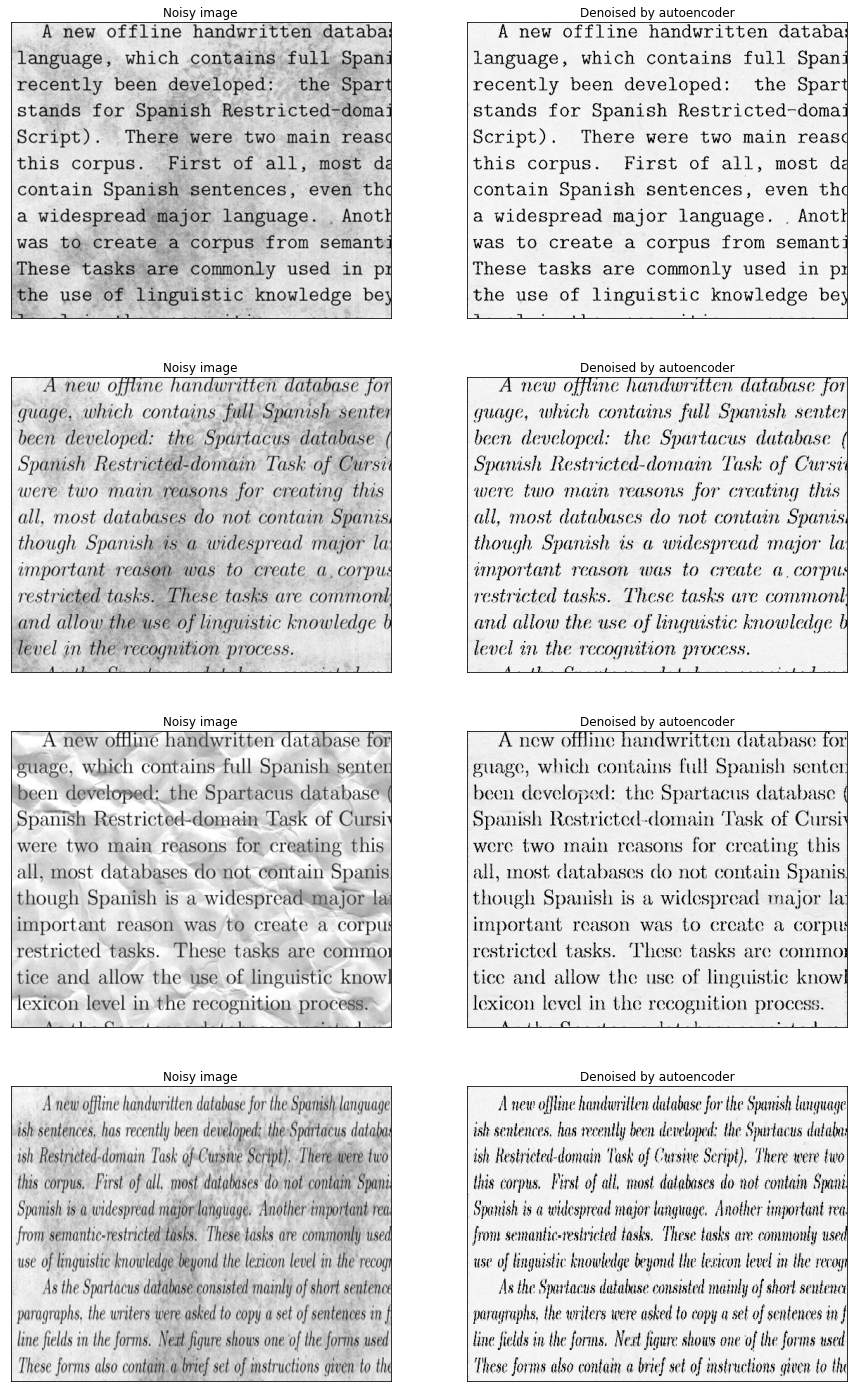

In [85]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_val[i][:,:,0], cmap='gray')
    plt.title('Noisy image')
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(preds[i][:, 0, :, 0], cmap='gray')
    plt.title('Denoised by autoencoder')
plt.show()